In [1]:
import os

os.chdir("../../")

import pandas as pd
import neuralprophet as nprophet
from matplotlib import pyplot as plt
import seaborn as sns
from src.data_handling import ingestion

sns.set_theme(context="paper", font_scale=1.15, style="whitegrid")

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Make NeuralProphet deterministic
nprophet.set_random_seed(0)

### Loading and preparing data

In [2]:
ts_data = ingestion.read_combined()
ts_data.dropna(subset=["consumption", "temperature_capped"], inplace=True)

# Reset index
ts_data.reset_index(inplace=True)

# Rename columns to match NeuralProphet requirements
ts_data.rename(columns={"consumption": "y", "index": "ds"}, inplace=True)

## Model

In [3]:
ts_data_selection = ts_data.drop(columns=["temperature"])

# Select columns
ts_data_selection = ts_data_selection[["ds", "y", "temperature_capped", "weekend"]]

(df_train, df_val) = nprophet.split_df(ts_data_selection, 5, 30)

In [4]:
model = nprophet.NeuralProphet(n_forecasts=365, n_lags=15)
model.add_future_regressor("temperature_capped", mode="additive")
model.add_future_regressor("weekend", mode="additive")
model.add_country_holidays(country_name="DE")

metrics = model.fit(df_train, validation_df=df_val, epochs=400, progress=None)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (45) is too small than the required number for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

### Validation loss over training

Text(0, 0.5, 'Loss')

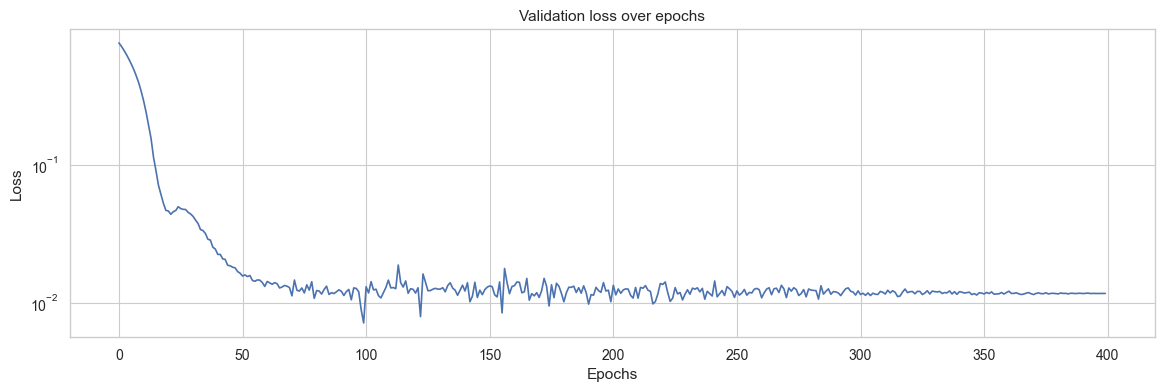

In [5]:
fig, ax = plt.subplots(figsize=(14, 4))

metrics["Loss_val"].plot(ax=ax)

# Make plot logaritmic
ax.set_yscale("log")

ax.set_title("Validation loss over epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

### Making predictions

In [6]:
future = model.make_future_dataframe(df_train, periods=365, n_historic_predictions=len(df_train), regressors_df=df_val[['temperature_capped', 'weekend']])
prediction = model.predict(future)

forecast = model.get_latest_forecast(prediction)
modelled_consumption = forecast.set_index("ds")["origin-0"].rename("y")
modelled_consumption = pd.concat([modelled_consumption, prediction.set_index("ds")["yhat1"].dropna().rename("y").iloc[:-1]], axis=0)

modelled_consumption = modelled_consumption.sort_index()

y = ts_data_selection.set_index("ds")["y"]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 1810 historic forecasts, reduced to 1795.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.954% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.954% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


(0.0, 7000000.0)

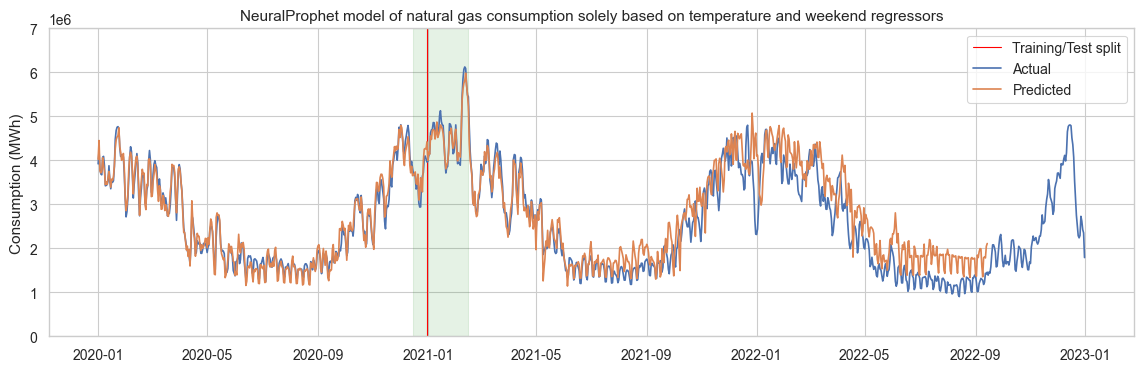

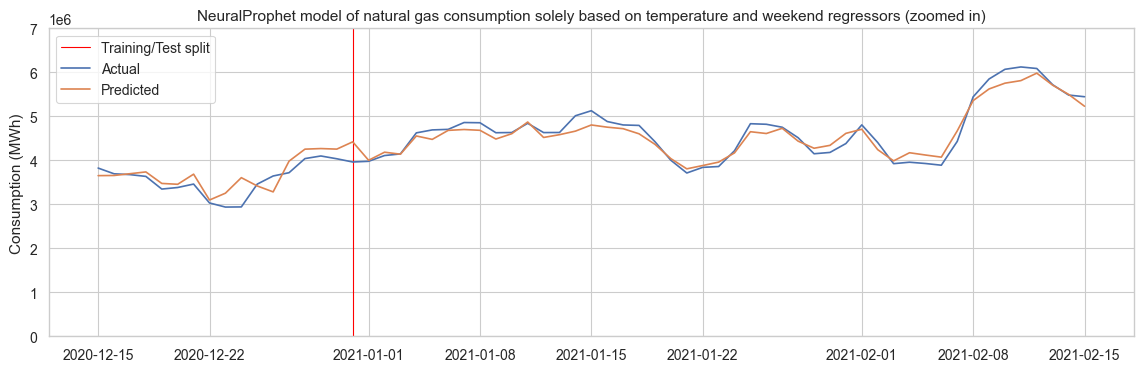

In [7]:
# Plot 1 - multiple years
fig, ax = plt.subplots(figsize=(14, 4))

ax.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax.axvspan(
    pd.Timestamp("2020-12-15"), pd.Timestamp("2021-02-15"), color="green", alpha=0.1
)
ax.plot(y["2020":], label="Actual")
ax.plot(modelled_consumption["2020":], label="Predicted")
ax.set_ylabel("Consumption (MWh)")
ax.legend()
ax.set_title("NeuralProphet model of natural gas consumption solely based on temperature and weekend regressors")
ax.set_ylim(0, 7 * 10**6)

# Plot 2 - zoomed in
fig, ax2 = plt.subplots(figsize=(14, 4))

ax2.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax2.plot(y["2020-12-15":"2021-02-15"], label="Actual")
ax2.plot(modelled_consumption["2020-12-15":"2021-02-15"], label="Predicted")
ax2.set_ylabel("Consumption (MWh)")
ax2.legend()
ax2.set_title("NeuralProphet model of natural gas consumption solely based on temperature and weekend regressors (zoomed in)")
ax2.set_ylim(0, 7 * 10**6)

### MAPE

In [8]:
# Mean Absolute Percentage Error (MAPE) for 60days after training data cutoff
mape_static_regressors = (
    abs(y["2021-01-01":"2021-02-28"] - modelled_consumption["2021-01-01":"2021-02-28"])
    / y["2021-01-01":"2021-02-28"]
).mean() * 100

mape_static_regressors_14days = (
    abs(y["2021-01-01":"2021-01-14"] - modelled_consumption["2021-01-01":"2021-01-14"])
    / y["2021-01-01":"2021-01-14"]
).mean() * 100

print(f"MAPE: {mape_static_regressors:.2f}%")
print(f"MAPE (14 days): {mape_static_regressors_14days:.2f}%")

MAPE: 2.69%
MAPE (14 days): 2.19%
